# Klasyfikacja opisów

Klasyfikacja opisów badań obrazowych do 4 kategorii:
- do kontroli       - brak zmian w płucach, występują inne zmiany
- guzek do kontroli - zmiany w płucach,
- guzek - guzki i guzy
- negatywny - pacjent zdrowy

In [1]:
import pandas as pd

import tabularycznych wyników badań

In [2]:
df = pd.read_csv('./wynik.csv')

In [3]:
df.wynik.value_counts()

negatywny, tylko zmiany dodatkowe    511
pozytywny do kontroli                431
pozytywny                             40
pozytywny, inne                        8
negatywny                              5
pozytywny, zmiany niemierzalne         2
Name: wynik, dtype: int64

### uproszczenie wyników

Po konsultacji z radiologiem dokonaliśmy wsępnej klasyfikacji wyników

In [4]:
wyniki = {'negatywny, tylko zmiany dodatkowe': 'płuca zdrowe, tylko zmiany dodatkowe',# mozliwy dodatkowy klasyfikator kierujący do konkretnego specjalisty
          'negatywny'                        : 'zdrowy', 
          'pozytywny do kontroli'            : 'guzek do kontroli', # kontrola zgodnie z wytycznymi (dodatkowy klasyfikator)
          'pozytywny'                        : 'guzek/guz podejrzany', # skierowanie do onkologa
          'pozytywny, inne'                  : 'guzek/guz podejrzany',  # skierowanie do onkologa
          'pozytywny, zmiany niemierzalne'   : 'guzek/guz podejrzany'} # skierowanie do onkologa (cięzko oddzielić gdzie kończy się guz)

In [5]:
df['wynik_uproszczony'] = df['wynik'].apply(lambda x: wyniki[x])

In [6]:
df['wynik_uproszczony'].value_counts()

do kontroli          511
guzek do kontroli    431
guzek                 50
negatywny              5
Name: wynik_uproszczony, dtype: int64

### Wyciągamy opisy badań

z plików tekstowych

In [7]:
def get_opis(ident):
    filename = f"opisy/{ident}.txt"
    with open(filename) as f:
        content = f.readlines()
        
    return '\n'.join(content)

In [25]:
assert len(get_opis('0050e201cce68367a62777cd6a68c52580825f75bf6f6a07dc9ab221bfde3e3f')) > 10

In [9]:
df['opis'] = df['identyfikator'].apply(get_opis)

# Klasyfikacja opisów do kategorii

Wykorzystano bibliotekę [fast.ai](https://docs.fast.ai/tutorial.text.html) i jej interfejs aplikacyjny z racji na prostotę użycia.

In [26]:
from fastai.text.all import *

In [27]:
df_for_model = df[['opis', 'wynik_uproszczony']].rename(columns={'wynik_uproszczony': 'result', 'opis': 'description'})

dls = TextDataLoaders.from_df(df_for_model)

In [29]:
dls.show_batch()

,text,category
0,"xxbos wynik wątpliwy + zmiany dodatkowe . xxup tk xxup klp / xxunk . xxup xxunk bez kontrastu xxunk wykonano w ramach npzchn . xxmaj guzki : xxup s6l - wielkosci ok . 2 x 2 x 2 mm , owalany , równe zarysy , bez zwapnień , miąższowy . xxup s6p - wielkosci ok . 3 x 3 x 3 mm , owalany , równe zarysy , bez zwapnień , xxunk guzki niespecyficzne , najprawdopodobniej bliznowate / pozapalne . xxmaj zmiany dodatkowe : xxmaj drobny ok . 1 cm podopłucnowy pęcherz powietrzny w xxup s6l . xxmaj pojedyncze węzły chłonne wielkosci do ok . 9 mm przytchawicze . xxmaj stan po złamaniu odc przednich żeber po stronie lewej . xxmaj duże ( odcinkowo ) zmiany zwyrodnieniowo w kręgosłupie piersiowym . xxmaj poza tym : xxmaj płuca prawidłowo powietrzne , bez innych zmian ogniskowych lub strukturalnych . xxmaj struktury śródpiersia",guzek do kontroli
1,"xxbos xxmaj wynik wątpliwy . xxmaj obecność zmian dodatkowych . xxmaj proponowana kontrola za ok . 12 mies . xxmaj wynik wątpliwy . xxmaj obecność zmian dodatkowych . xxmaj proponowana kontrola za ok . 12 mies . xxmaj badanie w ramach npzchn . xxmaj xxunk xxup xxunk / 6p - dwa xxunk guzki wielkosci ok . 5 x 5 x 7 mm i 4 x 4 x 5 mm , owalne , równe zarysy , bez zwapnień , podopłucnowe , xxunk xxup s6p - wielkosci ok . 2 x 2 x 2 mm , okrągły , równe zarysy , bez zwapnień , xxunk xxup s1 / 2l - wielkosci 2 x 2 x 3 mm , okrągły , nieco xxunk , bez zwapnień , xxunk xxup xxunk wielkosci ok . 2 x 2 x 2 mm , okrągły , równe zarysy , bez zwapnień , xxunk xxup xxunk wielkosci ok",guzek do kontroli
2,"xxbos xxmaj guz dolnego xxunk wnęki prawej , do xxunk w xxunk z powiększonymi xxunk xxunk wnęki prawej w xxunk niedodmy , xxunk oskrzele do płat środkowego , oraz do podstawnych segmentów płata dolnego prawego , znacznie xxunk oskrzele do seg . 6 prawego oraz w mniejszym stopniu do płata górnego . w seg . 2 prawym guz o wym . xxunk mm , w seg . 3 o śr . ok 14 mm , poza tym kilka xxunk w płucu prawym . xxmaj płat dolny prawym z xxunk i drobnoguzkowymi zmianami , mogą odpowiadać zalegającej wydzielinie w drogach oddechowych . xxmaj płyn w prawej jamie opłucnowej grubości warstwy do 15 mm przy tylnej ścianie klp . xxmaj guz w xxunk z powiększonymi xxunk xxunk wnęki prawej w xxunk niedodmy , xxunk oskrzele do płat środkowego , oraz do podstawnych segmentów płata dolnego prawego , znacznie xxunk oskrzele do seg",guzek
3,xxbos w płucach kilka guzków : radiologicznie najbardziej podejrzany w seg . 6 lewym o nierównych obrysach o wym . xxunk mm . xxmaj celowa kontrola za ok 6 miesiące.w płucach kilka guzków : największy xxunk w seg . 6 lewym o nieco nierównych obrysach xxunk konieczna kontrola za ok 6 miesiące . < br > poza tym owalne o dość gładkich obrysach miąższowe guzki : w języczku o wym . 6x5 mm oraz w seg . 8 lewym 6x5mm- czy tylko zalegająca wydzielina w drogach oddechowych ? xxmaj do kontroli.<br > poza tym kilka podopłucnowych guzków- największy w seg . 9 prawym 7x5mm- mogą odpowiadać wewnątrzpłucnym węzłom chłonnym . xxmaj płuca z objawami rozedmy z największym xxunk xxunk w prawym szczycie o wym . 8x6 cm . xxmaj płuca z rozlanym pogrubieniem ścian oskrzeli . < br > w płucach kilka guzków : największy xxunk w seg . 6,guzek do kontroli
4,"xxbos xxmaj guzek z rozpadem w płacie dolnym lewym- onkologicznie podejrzany . xxmaj do xxunk z rozpadem w płacie dolnym lewym w seg . 6 o wym . ok xxunk mm xxunk do szczeliny międzypłatowej skośnej , o pozaciąganych obrysach- onkologicznie podejrzany . xxmaj konieczne pogłębienie diagnostyki . < br > xxunk w seg . 6 lewym drobnoplamiste zagęszczenia . < br > poza tym w obu płucach w płatach górnych oraz w mniejszym stopniu w płacie środkowym liczne guzki ze xxunk największy w seg . 1 prawym o wym . xxunk mm z pasmowatymi zagęszczeniami i drobnymi rozstrzeniami xxunk najpewniej zmiany po tbc . xxmaj guzek z rozpadem w płacie dolnym lewym w seg . 6 o wym . ok xxunk mm xxunk do szczeliny międzypłatowej skośnej , o pozaciąganych obrysach- onkologicznie podejrzany .

In [30]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, pretrained=False)

SuggestedLRs(valley=0.0030199517495930195)

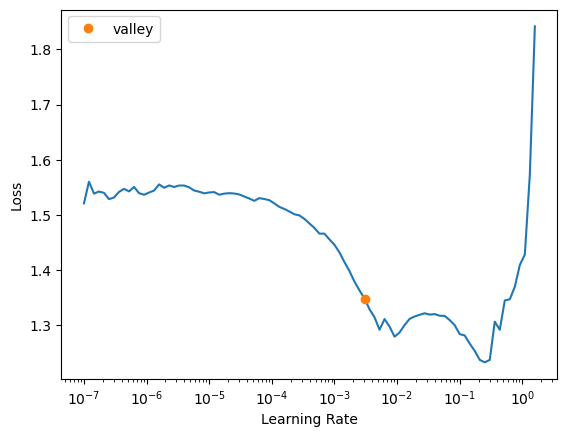

In [22]:
learn.lr_find()

In [33]:
def do_train(epochs, lr):
    learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy, pretrained=False)
    learn.fine_tune(epochs, lr)
    return learn

In [34]:
do_train(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.482859,1.349705,0.442211,00:14


epoch,train_loss,valid_loss,accuracy,time
0,1.342813,1.328949,0.442211,00:44
1,1.169192,1.074418,0.663317,00:43
2,0.994578,0.830544,0.809045,00:42
3,0.845049,0.760566,0.718593,00:43
4,0.737403,0.575359,0.854271,00:44
5,0.663742,0.490123,0.869347,00:42


In [36]:
do_train(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.496381,1.315346,0.512563,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.305910,1.294960,0.512563,00:42
1,1.164663,1.127806,0.512563,00:46
2,1.012367,0.896785,0.537688,00:42
3,0.865903,0.723689,0.693467,00:42
4,0.755327,0.645275,0.713568,00:41
5,0.662720,0.437815,0.864322,00:41
6,0.599273,0.455314,0.864322,00:41
7,0.539583,0.421598,0.884422,00:41
8,0.490467,0.405866,0.874372,00:42
9,0.447089,0.398148,0.874372,00:42


### kategoryzacja opisów

In [24]:
learn.predict(df['opis'].values[0])

('do kontroli', tensor(0), tensor([0.6390, 0.1034, 0.1691, 0.0886]))